In [133]:
import subprocess
import calendar
from geopy.geocoders import Nominatim
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn import preprocessing
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [134]:
df = pd.read_csv('result/all_strava_activities.csv')
print('Dataframe Shape: ', df.shape)
df.head()

Dataframe Shape:  (1154, 62)


,Unnamed: 0.1,Unnamed: 0,resource_state,name,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,...,pr_count,total_photo_count,has_kudoed,suffer_score,athlete.id,athlete.resource_state,map.id,map.summary_polyline,map.resource_state,average_temp
0,0,0,2,Afternoon Run,4845.9,1409,1430,20.0,Run,Run,...,0,0,False,36.0,50715143,1,a9359892211,oj~nG|fkoVBK^YJIZIlACTFFFFJ@NHnCPrALhDV~JLhBBf...,2,NaN
1,1,1,2,Morning Run,12897.5,3295,3511,33.0,Run,Run,...,0,0,False,155.0,50715143,1,a9356990196,oi~nGzfkoVIWBGHEb@In@En@BHFL\BdBPnBAnAJjBGj@Lv...,2,NaN
2,2,2,2,Evening Run,14502.5,4346,4388,57.0,Run,Run,...,2,1,False,119.0,50715143,1,a9354064678,mi~nG~ekoV`@STCb@A`@ITKBI?M[eCQkDIcACsAB_@d@qB...,2,NaN
3,3,3,2,Evening Run,14503.7,3719,3787,59.0,Run,Run,...,4,0,False,165.0,50715143,1,a9347780932,_j~nGpfkoVr@WVE`AEV@HBDHBLCdCGFIBwBX{@DcBX}@Bg...,2,NaN
4,4,4,2,Morning Run,4851.5,1262,1262,24.0,Run,Run,...,0,0,False,53.0,50715143,1,a9344407126,yj~nGbfkoV|C]J?HBDJT|CGh@?jBFn@RvAC`@Ip@Kb@IjA...,2,NaN


In [135]:
null_df = [[col, df[col].isnull().sum()] for col in df.columns]
print('Null Data:', df.isnull().sum().sum())
list(filter(lambda x: x[1]>0, null_df))

Null Data: 12940


[['workout_type', 203],
 ['location_city', 1154],
 ['location_state', 1154],
 ['location_country', 1154],
 ['gear_id', 310],
 ['average_cadence', 1098],
 ['average_watts', 1057],
 ['max_watts', 1098],
 ['weighted_average_watts', 1098],
 ['kilojoules', 1057],
 ['device_watts', 1057],
 ['average_heartrate', 114],
 ['max_heartrate', 114],
 ['elev_high', 236],
 ['elev_low', 236],
 ['upload_id', 99],
 ['upload_id_str', 99],
 ['external_id', 99],
 ['suffer_score', 114],
 ['map.summary_polyline', 236],
 ['average_temp', 1153]]

In [136]:
selected_columns = ['distance', 'moving_time', 'elapsed_time', 'sport_type', 'id', 'start_date_local',
                    'achievement_count', 'comment_count', 'athlete_count', 'start_latlng', 'end_latlng',
                    'average_speed', 'max_speed', 'average_heartrate', 'max_heartrate', 'elev_high', 'elev_low',
                    'upload_id', 'external_id', 'pr_count', 'map.summary_polyline']
df = df[selected_columns]


In [137]:
df['start_date_local'] = pd.to_datetime(df['start_date_local'], errors='coerce')
df = df.sort_values(by='start_date_local')

df['weekday'] = df['start_date_local'].map(lambda x: x.weekday)
df['start_time'] = df['start_date_local'].dt.time
df['start_time'] = df['start_time'].astype(str)
df['start_date'] = df['start_date_local'].dt.date

df = df.drop('start_date_local', 1)

df.head()

/var/folders/0c/940mw5n10rx6w8l0fkdgvq8h0000gn/T/ipykernel_38460/2875910738.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop('start_date_local', 1)


,distance,moving_time,elapsed_time,sport_type,id,achievement_count,comment_count,athlete_count,start_latlng,end_latlng,...,max_heartrate,elev_high,elev_low,upload_id,external_id,pr_count,map.summary_polyline,weekday,start_time,start_date
753,8648.5,2221,2422,Run,3069463222,0,0,2,"[44.748376, -93.129621]","[44.748336, -93.129657]",...,NaN,303.7,286.9,3.276221e+09,garmin_push_4511208075,0,i|bpGdklwPCiAUISAc@?g@DOO]i@So@Eu@@e@Lk@Z}@T_A...,0,15:23:56,2020-02-03
752,4631.3,1253,1385,Run,3072228195,0,0,2,"[44.748389, -93.129608]","[44.748273, -93.129743]",...,179.0,300.9,289.5,3.279292e+09,E4250FC9-57CA-46C3-B748-3AF216EDF745,0,k|bpG`klwPh@FM{@ZOXGz@GzBAj@i@jAc@JQFYD_CBsEDM...,1,15:37:11,2020-02-04
751,6437.4,1739,1739,Run,3072303734,0,0,1,[],[],...,NaN,NaN,NaN,NaN,NaN,0,NaN,1,16:05:06,2020-02-04
750,8729.6,2311,2388,Run,3078005005,5,0,1,"[44.74815, -93.129545]","[44.748279, -93.129753]",...,192.0,302.8,273.5,3.285729e+09,45645AB3-23E9-4724-8D84-E239457BE5F8,5,}zbpGtjlwPc@y@CMy@D{@?k@q@Uc@GW@k@NgA^{ATmA@k@...,3,15:28:11,2020-02-06
749,9131.7,2130,2296,Run,3080549293,6,0,2,"[44.748293, -93.129677]","[44.748223, -93.129327]",...,196.0,300.7,288.6,3.288566e+09,CFCE9EEA-0F74-4FBB-BD27-263E27C60717,6,y{bpGnklwPGw@?e@OIKAWLI@c@?UEMIOUYe@Qe@E[@o@Lq...,4,15:21:18,2020-02-07


In [138]:
df['elev_high'] = df['elev_high'].fillna(value=0)
df['elev_low'] = df['elev_low'].fillna(value=0)
df['upload_id'] = df['upload_id'].fillna(value='unknown')
df['external_id'] = df['external_id'].fillna(value='unknown')
df['map.summary_polyline'] = df['map.summary_polyline'].fillna(value='unknown')
df['average_heartrate'] = df['average_heartrate'].fillna(value=df['average_heartrate'].mean())
df['max_heartrate'] = df['max_heartrate'].fillna(value=df['max_heartrate'].mean())

df['moving_time_minutes'] = round(df['moving_time']/60, 2)
df['distance_mi'] = df['distance'] / 1609.344
df['pace'] = df['moving_time_minutes'] / df['distance_mi']

df['elev'] = df['elev_high'] - df['elev_low']
df['year']= df['start_date'].map(lambda x: x.year)

In [139]:
def get_city_state_from_value(value):
    if value == '[]':
        return 'unknown'
    value = value.replace('[','').replace(']','')
    if value != ['']:
        result = geolocator.reverse(value).address
    else:
        result = 'unknown'
    return result

geolocator = Nominatim(user_agent="strava_exploration_data")
df['location'] = df['start_latlng'].map(get_city_state_from_value)

In [140]:
df['pace_sub_6'] = np.where(df['pace']<=6, True, False)
df.head()

,distance,moving_time,elapsed_time,sport_type,id,achievement_count,comment_count,athlete_count,start_latlng,end_latlng,...,weekday,start_time,start_date,moving_time_minutes,distance_mi,pace,elev,year,location,pace_sub_6
753,8648.5,2221,2422,Run,3069463222,0,0,2,"[44.748376, -93.129621]","[44.748336, -93.129657]",...,0,15:23:56,2020-02-03,37.02,5.373929,6.888815,16.8,2020,"Irish Sports Dome, 13901, Robert Trail South, ...",False
752,4631.3,1253,1385,Run,3072228195,0,0,2,"[44.748389, -93.129608]","[44.748273, -93.129743]",...,1,15:37:11,2020-02-04,20.88,2.877756,7.255652,11.4,2020,"Irish Sports Dome, 13901, Robert Trail South, ...",False
751,6437.4,1739,1739,Run,3072303734,0,0,1,[],[],...,1,16:05:06,2020-02-04,28.98,4.000015,7.244973,0.0,2020,unknown,False
750,8729.6,2311,2388,Run,3078005005,5,0,1,"[44.74815, -93.129545]","[44.748279, -93.129753]",...,3,15:28:11,2020-02-06,38.52,5.424322,7.101348,29.3,2020,"Irish Sports Dome, 13901, Robert Trail South, ...",False
749,9131.7,2130,2296,Run,3080549293,6,0,2,"[44.748293, -93.129677]","[44.748223, -93.129327]",...,4,15:21:18,2020-02-07,35.50,5.674175,6.256416,12.1,2020,"Irish Sports Dome, 13901, Robert Trail South, ...",False


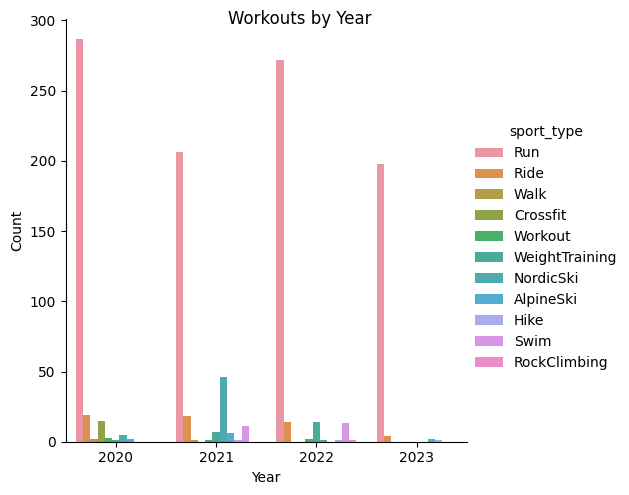

In [141]:
fig = sns.catplot(x='year', hue='sport_type', data=df, kind='count')
fig.fig.suptitle('Workouts by Year')
fig.set_xlabels('Year')
fig.set_ylabels('Count')
fig

Slope: 0.4190323731236025


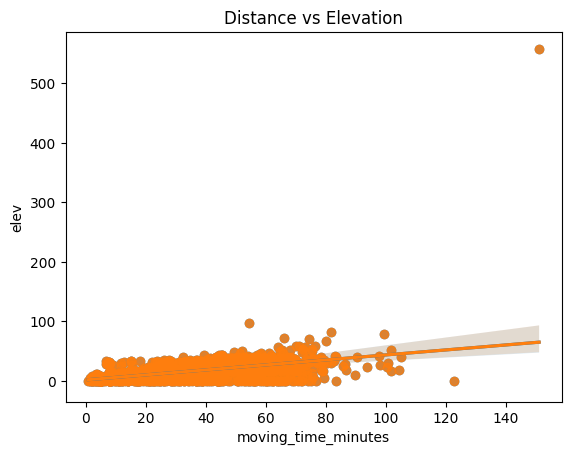

In [142]:
runs = df.loc[df['sport_type'] == 'Run']
p = sns.regplot(x='moving_time_minutes', y = 'elev', data=runs)

slope, intercept, r, p, sterr = scipy.stats.linregress(x=p.get_lines()[0].get_xdata(),
                                                       y=p.get_lines()[0].get_ydata())

sns.regplot(x='moving_time_minutes', y = 'elev', data=runs).set_title("Distance vs Elevation")

print('Slope: ' + str(slope))

Slope: 0.0017694730681268075


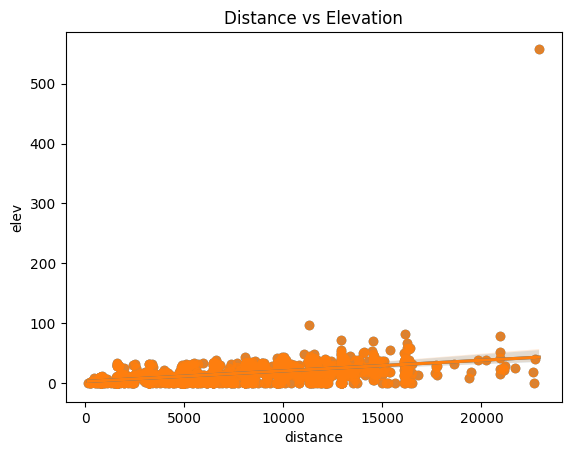

In [143]:
p = sns.regplot(x='distance', y = 'elev', data=runs)

slope, intercept, r, p, sterr = scipy.stats.linregress(x=p.get_lines()[0].get_xdata(),
                                                       y=p.get_lines()[0].get_ydata())

sns.regplot(x='distance', y = 'elev', data=runs).set_title("Distance vs Elevation")

print('Slope: ' + str(slope))

/var/folders/0c/940mw5n10rx6w8l0fkdgvq8h0000gn/T/ipykernel_38460/1473486282.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  runs.groupby('weekday').mean()['moving_time_minutes'].plot.bar()


<Axes: xlabel='weekday'>

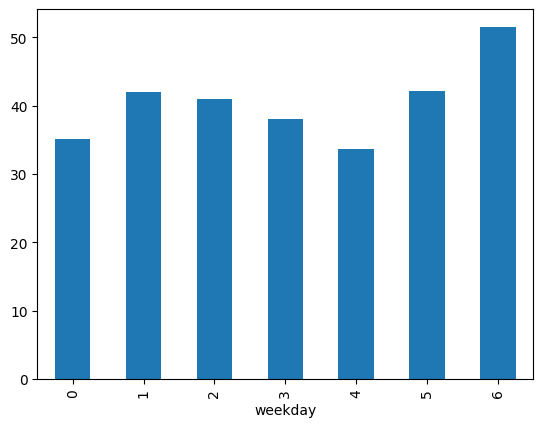

In [144]:
runs.groupby('weekday').mean()['moving_time_minutes'].plot.bar()

/var/folders/0c/940mw5n10rx6w8l0fkdgvq8h0000gn/T/ipykernel_38460/2582929615.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  runs.groupby('weekday').mean()['distance'].plot.bar()


<Axes: xlabel='weekday'>

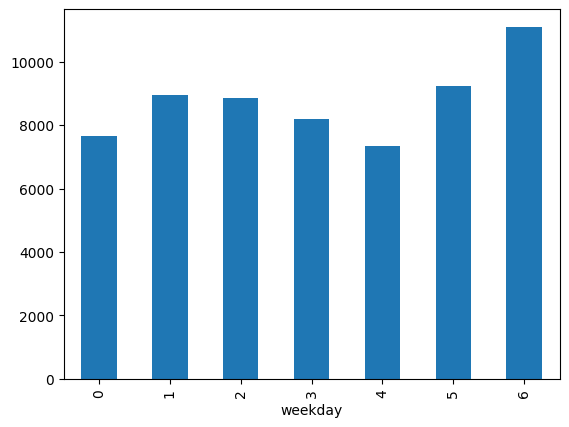

In [145]:
runs.groupby('weekday').mean()['distance'].plot.bar()

Slope: 0.006586944899316404


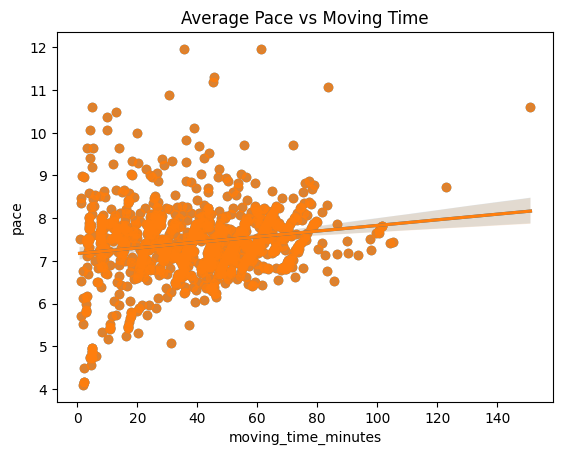

In [146]:
p = sns.regplot(x='moving_time_minutes', y = 'pace', data=runs)

slope, intercept, r, p, sterr = scipy.stats.linregress(x=p.get_lines()[0].get_xdata(),
                                                       y=p.get_lines()[0].get_ydata())

sns.regplot(x='moving_time_minutes', y = 'pace', data=runs).set_title("Average Pace vs Moving Time")

print('Slope: ' + str(slope))

Slope: 3.98077039645328e-06


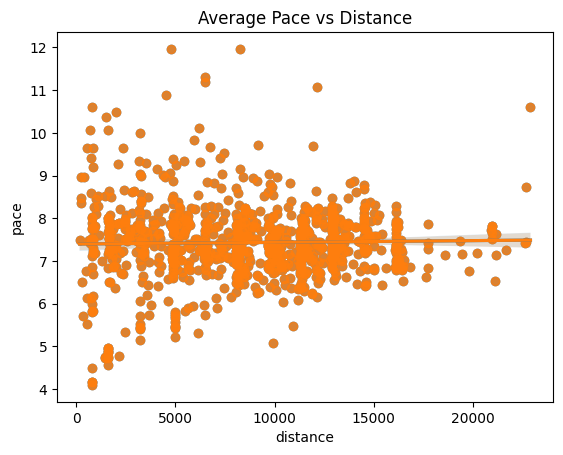

In [147]:
p = sns.regplot(x='distance', y = 'pace', data=runs)

slope, intercept, r, p, sterr = scipy.stats.linregress(x=p.get_lines()[0].get_xdata(),
                                                       y=p.get_lines()[0].get_ydata())

sns.regplot(x='distance', y = 'pace', data=runs).set_title("Average Pace vs Distance")

print('Slope: ' + str(slope))

Slope: 0.00017475465639744367


/var/folders/0c/940mw5n10rx6w8l0fkdgvq8h0000gn/T/ipykernel_38460/1712773897.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


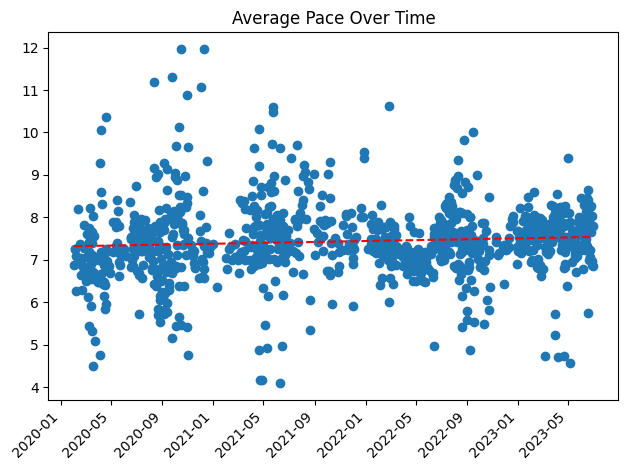

In [148]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

x = np.asarray(runs.start_date)
y = np.asarray(runs.pace)

ax1.plot_date(x, y)
ax1.set_title('Average Pace Over Time')

x2 = mdates.date2num(x)
z=np.polyfit(x2,y,1)
p=np.poly1d(z)
plt.plot(x,p(x2),'r--')
fig.autofmt_xdate(rotation=45)
fig.tight_layout()
fig.show()
print('Slope: ' + str(z[0]))

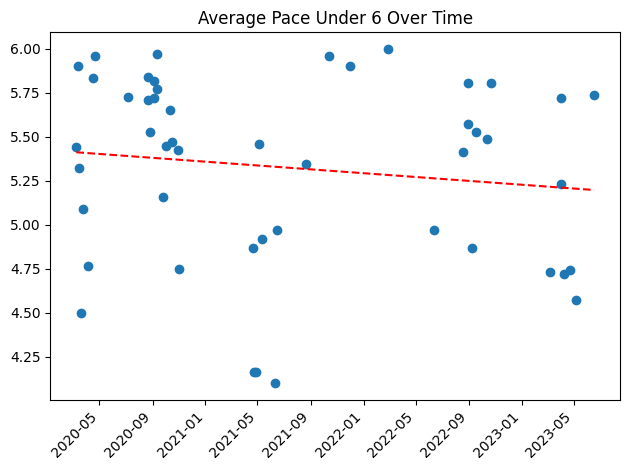

Slope: -0.0001796547238215832


In [149]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

x = np.asarray(runs.start_date)
y = np.asarray(runs.pace)

filtered_x = x[y < 6]
filtered_y = y[y < 6]

ax1.plot_date(filtered_x, filtered_y)
ax1.set_title('Average Pace Under 6 Over Time')

x2 = mdates.date2num(filtered_x)
z = np.polyfit(x2, filtered_y, 1)
p = np.poly1d(z)
plt.plot(filtered_x, p(x2), 'r--')
fig.autofmt_xdate(rotation=45)
fig.tight_layout()
plt.show()
print('Slope: ' + str(z[0]))

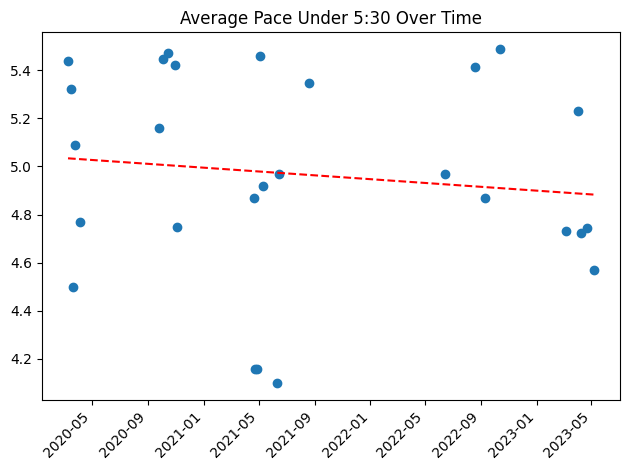

Slope: -0.0001308023340345203


In [150]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

x = np.asarray(runs.start_date)
y = np.asarray(runs.pace)

filtered_x = x[y < 5.5]
filtered_y = y[y < 5.5]

ax1.plot_date(filtered_x, filtered_y)
ax1.set_title('Average Pace Under 5:30 Over Time')

x2 = mdates.date2num(filtered_x)
z = np.polyfit(x2, filtered_y, 1)
p = np.poly1d(z)
plt.plot(filtered_x, p(x2), 'r--')
fig.autofmt_xdate(rotation=45)
fig.tight_layout()
plt.show()
print('Slope: ' + str(z[0]))

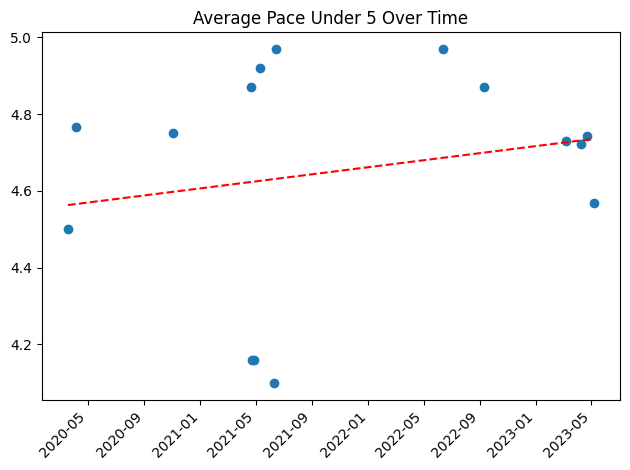

Slope: 0.00015100258217973803


In [151]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

x = np.asarray(runs.start_date)
y = np.asarray(runs.pace)

filtered_x = x[y < 5]
filtered_y = y[y < 5]

ax1.plot_date(filtered_x, filtered_y)
ax1.set_title('Average Pace Under 5 Over Time')

x2 = mdates.date2num(filtered_x)
z = np.polyfit(x2, filtered_y, 1)
p = np.poly1d(z)
plt.plot(filtered_x, p(x2), 'r--')
fig.autofmt_xdate(rotation=45)
fig.tight_layout()
plt.show()
print('Slope: ' + str(z[0]))

/var/folders/0c/940mw5n10rx6w8l0fkdgvq8h0000gn/T/ipykernel_38460/2207610790.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = runs.corr()


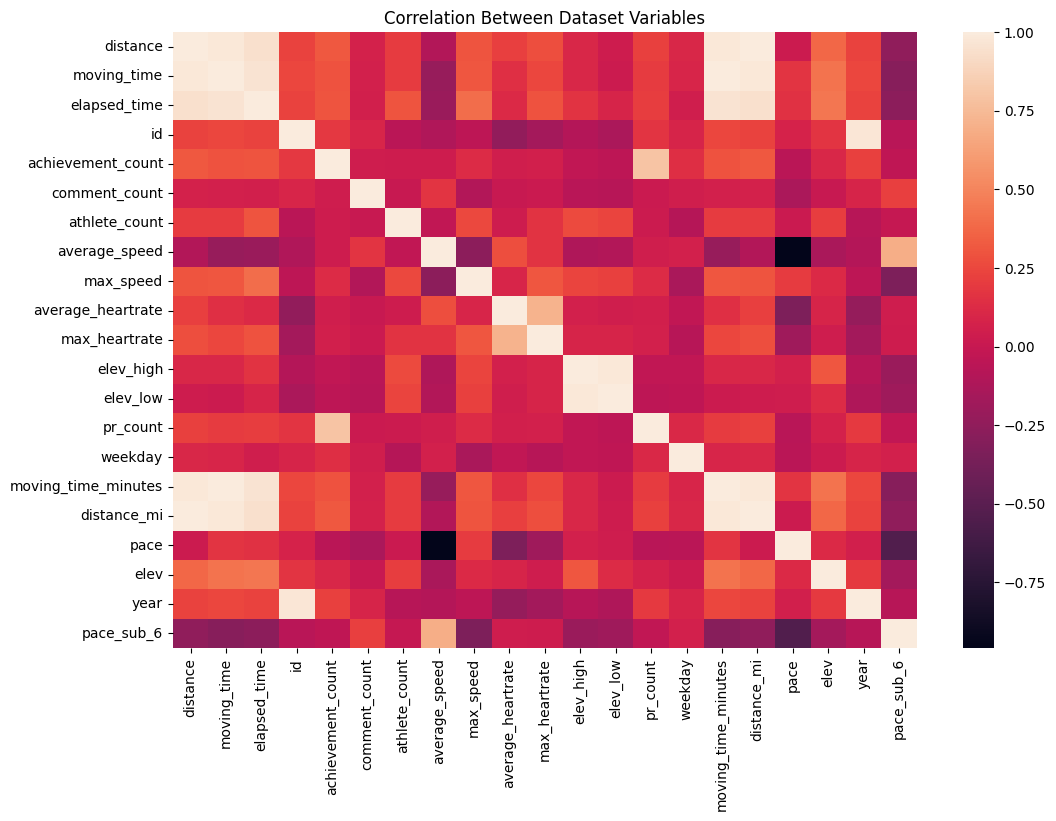

In [152]:
corr = runs.corr()
plt.figure(figsize = (12,8))
sns.heatmap(corr, fmt=".2f");
plt.title('Correlation Between Dataset Variables')
plt.show()